dimensions of the edges frame (933, 3)
number_edges = 933, each edge has 2 nodes with the associated time
dimensions of the adjacent matrix:  (376, 376)
Starting from node 176, one path to cover all the nodes in 30534.0 seconds is: 
     Nodes station                          stations
0              176                         Madeleine
1              281                         Pyramides
2              282                         Pyramides
3              228     Palais Royal, Musée du Louvre
4              255                         Pont-Neuf
5               71                          Châtelet
6              254                        Pont-Marie
7              345                     Sully Morland
8              149                           Jussieu
9              241                       Place Monge
10              49                 Censier Daubenton
11             164                      Les Gobelins
12             244                    Place d'Italie
13             352       

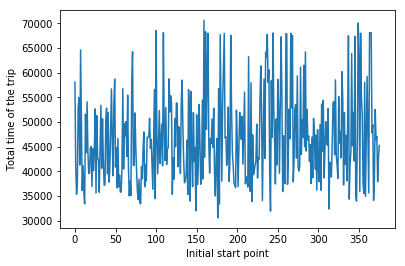

In [2]:

############# ------------Metro project                Benjamin Lepers, 26/01/2019

# Goal of the program: with one metro ticket valid 20h = 72000 s, find a route to go
# through all the paris stations.
# A station can have many nodes and going through all the nodes implies
# necessarly to go through all the station. The reverse is not true: going through 
# all the stations does not implies to go through all the nodes. In the program,
# we generate admissible paths (continuous) to go through all the nodes for any 
# starting node.

# The metro_complet.txt provide the connection between the nodes and the time duration between them.
# In this program, we don't use a pre-built heuristic such as simulated annealed or 
# genetic algorithm.
# Instead, a custom made "heuristic algorithm " is made by implementing the two following rules:
# -  choose the stations by the least visited ones
# -  by the shortest in time. 
# the first rule (by number of visit)  is used prior to  the second one (shortest route
# in time duration).
# For cases where 2 or more nodes have been visited the same number of time 
# and they have the same time duration from the current node, we decide randomly
# between the selected nodes to choose the next node (this is the only case
# where a function random is used. line 158 in the code)

###----1 steps : load the file, make a dataframe
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt


#----------------------------creation of a vertice panda data frame and an edge data frame with the metro_complet.txt file
#############################
#############################

#----------------------------read file, the file metro_complet.txt should be in the same directory as this program
#############################creation of a vertice panda data frame and a edge data frame
#############################
#############################

df1 = pd.read_csv('metro_complet.txt',sep = '|', encoding = "latin-1", header= 0)

#-------------create the data frame for the stations and corresponding nodes
df_vertice = df1.head(376)
df_vertice.columns = ['Vertice']
df_vertice = pd.DataFrame(df_vertice.Vertice.str.split(' ',1).tolist(), columns = ['node','station'] )

#-------------convert the columne " node" into an integer type
df_vertice.loc[:,'node'] = pd.to_numeric(df_vertice.loc[:,'node'])
df_vertice.dtypes

#-------------create a data frame for the edges.
df_edge = df1[376:]
df_edge = df_edge.drop([376])
df_edge.reset_index(drop=True, inplace=True)
df_edge.columns = ['edges']
df_edge = pd.DataFrame(df_edge.edges.str.split(' ',2).tolist(), columns =  ['dep', 'arr', 'time']) 

#------------ convert the nodes into integers and the time into a float
df_edge.loc[:,'dep'] = pd.to_numeric(df_edge.loc[:,'dep'])
df_edge.loc[:,'arr']= pd.to_numeric(df_edge.loc[:,'arr'])
df_edge.loc[:,'time']= pd.to_numeric(df_edge.loc[:,'time'])


#-------------look the dimmensions
print("dimensions of the edges frame", df_edge.shape)
(number_edges, nodes) = (df_edge.shape[0], df_edge.shape[1]-1)
print("number_edges = {0}, each edge has {1} nodes with the associated time".format(number_edges,nodes))

#--------------number of different nodes of the stations, nodes_dep = nodes_arr = 376
nodes_dep = df_edge.loc[:,"dep"].nunique()
nodes_arr = df_edge.loc[:,"arr"].nunique()

######################################FONCTIONS

# 1) contmatric: continuity matrix: the matrix contains the time between node i and node j. (located at the ieme row and jeme column)
# 2) choice: fonction that return the next node according to the current node and the history of visited nodes
# 3) choice_already_visited, is a helper function of choice, it make a choice a station among the ones already visited
# 4) mintime: fonction that returns the minimum time between 2 nodes, if they have the same time, and have been
#  visited the same number of time, a random choice is made between the nodes with the same time.
# 5) generatepath: fonction that returns the next node, the time between the current node and the next node and the visited nodes list
# 6) launch: to compute the path from a given node
# 7) printnames: to print the data frame with the nodes stations and the stations name of the path
# 8) scan_initnode: to compute the path for all initial node station (0 to 376)

# 1)---------------construction of the adjacent matrix
#  i is a departure node 
#  j is an arrival node

def contmatrix(nodes_dep):
    """construct the continuity matrix, square matrix (nodes_dep = nodes_arr), the distance between 
      the ieme  and jeme nodes is located at the ieme row and jeme column: mat[i,j]"""
    mat = np.zeros((nodes_dep, nodes_dep))
    for i in range(number_edges):
        mat[df_edge.loc[i,"dep"],df_edge.loc[i,"arr"]] = df_edge.loc[i,"time"]
    return mat
mat = contmatrix(nodes_dep)      
print("dimensions of the adjacent matrix: ", mat.shape)

# 2) fonction choice
def choice(current, pos_choice, visited):
    """fonction that takes a list of possible choices and the list of visited nodes, return the next node
    1) input: pos_choice, list of possible choice
    2) input: list of already visited node
    3) input: current node location
    3) output: next node location               
    4) rules of decision, if all nodes are not already in the visited list, chose the closest to the current node
    5) if  one node is not yet visited and the others already, chose the new one                                
    6) if 2 or more nodes are already visited, choose the one with the shortest time      
                                                                                        """
    not_visited = []
    already_visited = []
    selected = []
    for i  in range(len(pos_choice)):                                   # read the possible nodes 
        if pos_choice[i] not in visited:                                # if the node has not been visited, add it the not_visited list
            not_visited.append(pos_choice[i])
        else:
            already_visited.append(pos_choice[i])                       # otherwise add it to a list of already visited nodes
    if not_visited != []:                                               # if the not_visited list is not empty, choose the node of this list
        nextnode = mintime(current, not_visited, mat)                   #  closest in time to the current node                                                                    
    else:
        selected = choice_already_visited(already_visited, visited)     #  otherwise use the helper function to make a sublist among the already visited nodes
        nextnode = mintime(current, selected, mat)                      #  select  the next node with the mintime function                    
    return nextnode

# 3) fonction choice_already_visited
def choice_already_visited(list_possible, visited):
    """ fonction that take a list of possible stations, the list of 
        already visited statio. It returns a sublist of the best candidates
        based on the least visited criterion, it is an helper function of fonction choice"""
    occurence = []
    selected = []
    for i in range((len(list_possible))):
        occurence.append(visited.count(list_possible[i]))               # create a list of occurence
        
    for k in range(len(occurence)):
        if occurence[k] == min(occurence):
            selected.append(list_possible[k])                           # return a list of the least visited stations
    return selected                                                     # visited same number of time, otherwise min(occurence) will gives a list 
                                                                        # with one element, the min one.
# 4) fonction mintime                                                                       
def mintime(current, station, mat):                                       
    """fonction that returns the closest station in time from the 
    current node if 2 or more nodes are at the same distance in time
    and they have been visited the same number of time, the choice is
    made randomly between them. Here the random part is deactivate"""
    timelist = []
    index = []
    for i in range(len(station)):
        timelist.append(mat[current, station[i]])                        # create a list of time from  the current station to the others stations
                                                                        # read from the adjacent matrix mat
    for k in range(len(timelist)):
        if timelist[k]==min(timelist):
            index.append(k)
            if len(index)==1:                                           # if there is a unique closest node in time from current
                p = index[0]                                            # indice we need to find the station
            else:
                 #p = randint(min(index),max(index))                    # if node a the same distance in time, select randomly
                 p = min(index)                                         # could also use p = min(index) or p = max(index)
    return station[p]                                                   # here we choose p = max(index), because we found a good result with the inital node 
        
# 5) fonction generatepath
def generatepath(current, tau, visited, mat):                           # tau: time between 2 nodes
    """ fonction that returns the nextpoint and the remaining time given the current point
    input: current point, current time, visited station, adjacent matrix mat
    output: next point, time remaining, visited station updated"""
    possible_choice=[]
    for i in range(nodes_dep):                                          # iter over the row of the matrix
        if i == current:                                                # if currennt point is found, browse the colomn to find a possible path
            for j in range(nodes_dep):              
                if mat[i,j]!=0:                                         # thanks to the adjacent matrix we know when we have the continuity
                    possible_choice.extend([j])                         # create a list of possible next stations
                      
    nextnode = choice(current, possible_choice, visited)                  # pick the station thanks to the function choice
    tau = tau + mat[current, nextnode]                                   # update the remaining time
    
    visited.append(current)
    visited.append(nextnode)                                            # update visited station
    
    return [nextnode, tau, visited]

# 6) fonction launch
def launch(startnode = 176):
    """fonction to launch one calculation of a path for a given initial node
       return the list of nodes, the length of the list of nodes, the length of the 
       list of different nodes visited, and the total time """
    time_total = 0
    tau = 0                                                              # initial value
    number_total_nodes_paris = 376                                                      
    current = startnode                                                
    list_nodes = [startnode]
    result = []
    time_list = [] 
    visited = [] 
    time_limit = 72000
    while (time_total < time_limit):
        result = generatepath(current, tau, visited, mat)
        time_list.append(result[1])
        list_nodes.append(result[0])
        current = result[0]                                              # update the current point
        time_total = sum(time_list)
        number_total_nodes = len(list_nodes)
        number_different_nodes = len(set(list_nodes))                      
    
        if number_different_nodes == number_total_nodes_paris:
            break
    #print("number of total nodes station visited: ", number_total_nodes)
    #print("number of different nodes station visited: ", number_different_nodes)
    #print("time of the trip in s", time_total)
    #print("path of the trip: ", list_nodes)
    return [startnode, time_total, list_nodes, number_total_nodes]
    
#    Run the program, call function
result = launch()
list_nodes = result[2]
list_station_names = []

# 7) fonction printnames
def printnames(list_nodes):
    """fonction that print the name of the station """
    list_station_names = []
    for i in list_nodes:
            list_station_names.append(df_vertice.loc[i,'station'])
    return list_station_names
    #print("the name of the station are: ")
    #print(list_station_names)

list_station_names = printnames(list_nodes)
#  create a data from for the obtained solution
df_solution = pd.DataFrame()
df_solution['Nodes station'] = list_nodes
df_solution['stations'] = list_station_names

print("Starting from node {0}, one path to cover all the nodes in {1} seconds is: ".format(result[0], result[1]))
print(df_solution)

# to create a txt file solution in the local directory, uncomment it to write in the local directory
# df_solution.to_csv('solution.txt', header = True, sep = ' ',index_label = 'index', )

# create a function to loop over all the starting point an generate a plot with the time
# of the trip, versus the inital starting node station. This is how we found the best time with node = 176.
# for reproducibilty result, we use p = min(index) in the mintime function, but we could use p = randint(min(index),max(index))  

# 8) fonction scan_initnode
def scan_initnode():
    Initial_startpoint = []
    Total_time_list = []
    List_station = [j for j in range(376)]
    for i in range(376):
        result = launch(i)
        Total_time_list.append(result[1])
        Initial_startpoint.append(result[0])

    #print("Initial starting node:", Initial_startpoint)              
    #print("Total_time_list:", Total_time_list)
    plt.plot(List_station,Total_time_list)
    plt.xlabel("Initial start point")
    plt.ylabel("Total time of the trip")
    print("The shorstest path in time is {0} seconds and is obtained by starting from the node {1}, ({2})".format(min(Total_time_list),
                                             np.argmin(Total_time_list), df_vertice.loc[np.argmin(Total_time_list),'station']))
    
scan_initnode()                          # uncomment and run to sweep all the inital starting nodes (0 to 375)
                                           # simulation take about 4 min on my laptop.